In this notebook we will explore *manifold regularization* using Lyrics framework.



In [1]:
from lyrics.lyrics import (
    Domain,
    Predicate,
    Constraint,
    PointwiseConstraint,
)
from lyrics.world import current_world as world
import numpy as np
import tensorflow as tf
from sklearn import datasets as data
import matplotlib.pyplot as plt

In [2]:
np.random.seed(3)
tf.random.set_seed(3)

In [3]:
NB_UNSUPERVISED = 200
NB_SUPERVISED = 20
NB_TEST = 200

Create two circles where one is inside the other.

In [4]:
all_x, all_y = data.make_circles(n_samples=NB_UNSUPERVISED + NB_SUPERVISED + NB_TEST)

Take 200 unsupervised points.

In [5]:
unsupervised  = all_x[0:NB_UNSUPERVISED]

Take 20 supervised points.

In [6]:
sup_x, sup_y = all_x[NB_UNSUPERVISED:NB_UNSUPERVISED+NB_SUPERVISED].astype(np.float32), all_y[NB_UNSUPERVISED:NB_UNSUPERVISED+NB_SUPERVISED].reshape(-1,1).astype(np.float32)

Take 200 test points.

In [7]:
test_x, test_y = all_x[-NB_TEST:].astype(np.float32), all_y[-NB_TEST:].reshape(-1,1).astype(np.float32)

Plot the unsupervised, supervised and test points.

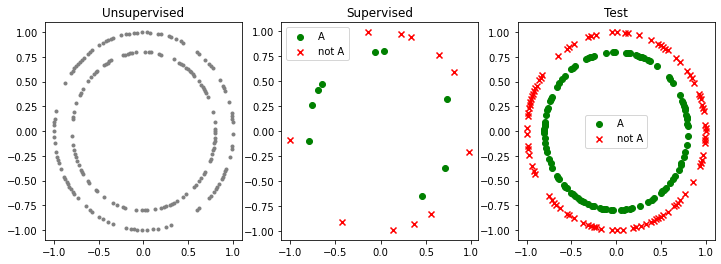

In [8]:
plt.figure(figsize=(12,4))
plt.subplot(1,3,1).title.set_text('Unsupervised')
plt.scatter(unsupervised[:,0],unsupervised[:,1], color="grey", marker=".")
plt.subplot(1,3,2).title.set_text('Supervised')
plt.scatter(sup_x[sup_y.reshape(-1,)==1][:,0],sup_x[sup_y.reshape(-1,)==1][:,1], color="green", marker="o", label="A")
plt.scatter(sup_x[sup_y.reshape(-1,)==0][:,0],sup_x[sup_y.reshape(-1,)==0][:,1], color="red", marker="x", label="not A")
plt.legend()
plt.subplot(1,3,3).title.set_text('Test')
plt.scatter(test_x[test_y.reshape(-1,)==1][:,0],test_x[test_y.reshape(-1,)==1][:,1], color="green", marker="o", label="A")
plt.scatter(test_x[test_y.reshape(-1,)==0][:,0],test_x[test_y.reshape(-1,)==0][:,1], color="red", marker="x", label="not A")
plt.legend()

plt.show()

Define a function used to say if two points are close to each other or not (we choose a threshold of .10).

In [9]:
def isClose(a, b):
    dist = tf.sqrt(tf.reduce_sum(tf.square(a - b), axis=1))
    return tf.where(dist < 0.10, tf.ones_like(dist), tf.zeros_like(dist))

Define a neural network to tell if a point is in the class *A* (e.g. the inner circle) or not (e.g. for the point in the outer circle) depending on its coordinates.

In [10]:
class FCL(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(FCL, self).__init__(**kwargs)
        self.model = tf.keras.Sequential([
            tf.keras.layers.Dense(30, activation='relu'),
            tf.keras.layers.Dense(1)
        ])
    def call(self, inputs):
        return self.model(inputs)
    
    def cost(self, y, x):
        y_hat = self.call(x)
        losses = tf.keras.losses.binary_crossentropy(y,y_hat, from_logits=True)
        return tf.reduce_mean(losses)

Instantiate a neural network.

In [11]:
fcl = FCL()

Define a pointwise constraint on the supervised data. In order to enforce the satisfaction of this constraint, this is associated with the weight value of 100.

In [12]:
ptc = PointwiseConstraint(fcl, sup_y, sup_x, weight=100)

Define a domain **points** that includes supervised and unsupervised data.

In [13]:
points = Domain('points', elements=np.concatenate([unsupervised, sup_x]))

Define a logical predicate *A* where A(p) is the degree of confidence (fuzzy value) that the point p
belongs to class A. This predicate uses the previously instantiated neural network as a low-level implementing function.

In [14]:
Predicate("A", domains=("points",), concrete_function=fcl)

Define a logical predicate CLOSE where CLOSE(p,q) is the degree of confidence that points p and q are close. This predicate uses the previously defined function isClose as backing function.

In [15]:
Predicate("CLOSE", domains=("points", "points"), concrete_function=isClose)

Define a constraint that states: for every two points: is they are close, then they should belong to the same class. Notice that we give a weight of 10 to this constraint. Thus this is 10 times less important that the pointwise constraint.

In [16]:
c = Constraint("forall p: forall q: CLOSE(p,q) -> (A(p) <-> A(q))", weight=10)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `

Define a standard training step. The model argument could be the pointwise constraint only, or the whole constrained world. The optimization is done with respect to the neural network parameters.

In [17]:
optimizer = tf.keras.optimizers.Adam()
@tf.function
def train_step(model):
    with tf.GradientTape() as tape:
        loss = model.loss()
        grads = tape.gradient(loss, fcl.trainable_variables)
    optimizer.apply_gradients(zip(grads, fcl.trainable_weights))
    return loss

Train a model for a number of epochs.

In [18]:
def train(model, nb_epochs):
    epochs = range(1,nb_epochs + 1)
    print('Loss at epoch 0 = {}'.format(model.loss()))
    for epoch in epochs:
        loss = train_step(model)
        if epoch % 1000 == 0:
            print('Loss at epoch {} = {}'.format(epoch, loss))

Train the model without the high level constraint (only using the pointwise constraint on the supervised data) for 5000 epochs.

In [19]:
train(ptc, 5000)

Loss at epoch 0 = 68.65508270263672
Loss at epoch 1000 = 25.239673614501953
Loss at epoch 2000 = 7.050135135650635
Loss at epoch 3000 = 2.285360336303711
Loss at epoch 4000 = 0.8955878019332886
Loss at epoch 5000 = 0.4033516049385071


Get the model's output on the supervised and test data.

In [20]:
test_y_hat = (tf.math.sigmoid(fcl(test_x)) > 0.5).numpy().astype(np.int8).reshape(-1,)
sup_y_hat = (tf.math.sigmoid(fcl(sup_x)) > 0.5).numpy().astype(np.int8).reshape(-1,)

Showing the results.

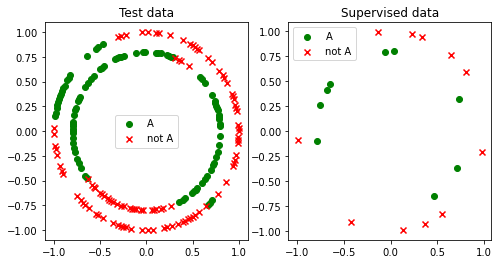

In [21]:
plt.figure(figsize=(8,4))
plt.subplot(1,2,1).title.set_text('Test data')
plt.scatter(test_x[test_y_hat==1][:,0],test_x[test_y_hat==1][:,1], color="green", marker="o", label="A")
plt.scatter(test_x[test_y_hat==0][:,0],test_x[test_y_hat==0][:,1], color="red", marker="x", label="not A")
plt.legend()
plt.subplot(1,2,2).title.set_text('Supervised data')
plt.scatter(sup_x[sup_y_hat==1][:,0],sup_x[sup_y_hat==1][:,1], color="green", marker="o", label="A")
plt.scatter(sup_x[sup_y_hat==0][:,0],sup_x[sup_y_hat==0][:,1], color="red", marker="x", label="not A")
plt.legend()
plt.show()

Continue training the model for more epochs but include the logic constraints.

In [22]:
train(world, 2000)

Loss at epoch 0 = 393.7416687011719
Loss at epoch 1000 = 92.19317626953125
Loss at epoch 2000 = 77.67439270019531


Get the model's output on the supervised and test data.

In [23]:
test_y_hat = (tf.math.sigmoid(fcl(test_x)) > 0.5).numpy().astype(np.int8).reshape(-1,)
sup_y_hat = (tf.math.sigmoid(fcl(sup_x)) > 0.5).numpy().astype(np.int8).reshape(-1,)

Showing the results.

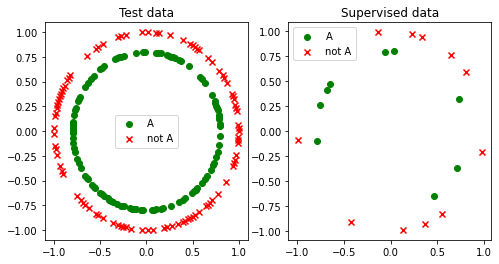

In [24]:
plt.figure(figsize=(8,4))
plt.subplot(1,2,1).title.set_text('Test data')
plt.scatter(test_x[test_y_hat==1][:,0],test_x[test_y_hat==1][:,1], color="green", marker="o", label="A")
plt.scatter(test_x[test_y_hat==0][:,0],test_x[test_y_hat==0][:,1], color="red", marker="x", label="not A")
plt.legend()
plt.subplot(1,2,2).title.set_text('Supervised data')
plt.scatter(sup_x[sup_y_hat==1][:,0],sup_x[sup_y_hat==1][:,1], color="green", marker="o", label="A")
plt.scatter(sup_x[sup_y_hat==0][:,0],sup_x[sup_y_hat==0][:,1], color="red", marker="x", label="not A")
plt.legend()
plt.show()